# FashionMNIST VAE

In [ ]:
#%pip install pyro-ppl==0.3.4

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import torchvision
import torchvision.transforms as tvt
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, Adamax, Adadelta, SGD, RMSprop
from torchvision import utils
from helper_functions import *
from sklearn.manifold import TSNE

In [2]:
print(pyro.__version__)
print(torch.__version__)
assert(pyro.__version__ == '0.3.4')
assert(torch.__version__ == '1.1.0')

0.3.4
1.1.0


### Define the simulation parameters

In [3]:
params = { 
    'CHANNELS' : 1,
    'WIDTH' : 28,
    'HEIGHT':28, 
    'DIM_Z':20,
    'SCALE': 1.0,
    'use_cuda' : torch.cuda.is_available()
    }
print(params)

{'HEIGHT': 28, 'use_cuda': True, 'CHANNELS': 1, 'DIM_Z': 20, 'SCALE': 1.0, 'WIDTH': 28}


### Get the data

torch.Size([4, 1, 28, 28])


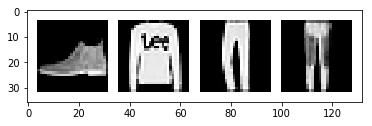

In [4]:
BATCH_SIZE = 512
kwargs = {'num_workers': 0, 'pin_memory': params["use_cuda"]}
data_dir = "/home/jupyter/REPOS/VAE_PYRO"
#data_dir = "/home/ldalessi/REPOS/VAE_PYRO"
#data_dir = "/Users/ldalessi/VAE_PYRO"


trainset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True, transform=tvt.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
testset = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True, transform=tvt.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)

imgs_test,labels = next(iter(testloader))
if(params['use_cuda']):
    imgs_test=imgs_test[:4].cuda()

print(imgs_test.shape)
show_batch(imgs_test,npadding=4)

# VAE in PYRO

In [5]:
from encoder_decoder import *
from vae import *
encoder = Encoder_CONV(params)
decoder = Decoder_CONV(params)
vae = VAE(params,encoder,decoder)

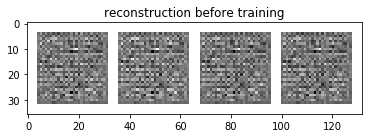

In [6]:
imgs_rec = vae.reconstruct(imgs_test)
show_batch(imgs_rec,nrow=4,npadding=4,title="reconstruction before training")
plt.savefig("rec_before_training.png")

In [7]:
pyro.clear_param_store()
pyro.set_rng_seed(0)

#optimizer_args = {'lr': 1E-6}
#scheduler_args = {'optimizer': torch.optim.RMSprop, 'step_size' : 1, 'gamma' : 1.5, 'optim_args' : optimizer_args}
#pyro_scheduler = pyro.optim.StepLR(scheduler_args)
#svi = SVI(vae.model, vae.guide, pyro_scheduler, loss=Trace_ELBO(num_particles=1))

optimizer = RMSprop({'lr': 1E-6})
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO(num_particles=1))

In [8]:
pr_hist_loss,pr_hist_lr = lr_finder(svi, 
                              loader=testloader, 
                              lr_start=1E-6, 
                              lr_multiplier=1.5, 
                              N_max_epoch=30, 
                              use_cuda=params['use_cuda'])

[epoch 000] train loss: 6040.5244 lr: 1.0000e-06
[epoch 001] train loss: 6023.0714 lr: 2.2500e-06
[epoch 002] train loss: 6004.6819 lr: 3.3750e-06
[epoch 003] train loss: 5980.2994 lr: 5.0625e-06
[epoch 004] train loss: 5945.0074 lr: 7.5937e-06
[epoch 005] train loss: 5886.6280 lr: 1.1391e-05
[epoch 006] train loss: 5751.0801 lr: 1.7086e-05
[epoch 007] train loss: 5266.7593 lr: 2.5629e-05
[epoch 008] train loss: 4301.2016 lr: 3.8443e-05
[epoch 009] train loss: 3441.5984 lr: 5.7665e-05
[epoch 010] train loss: 2913.7304 lr: 8.6498e-05
[epoch 011] train loss: 2541.5208 lr: 1.2975e-04
[epoch 012] train loss: 2272.3182 lr: 1.9462e-04
[epoch 013] train loss: 1812.2234 lr: 2.9193e-04
[epoch 014] train loss: 1230.9076 lr: 4.3789e-04
[epoch 015] train loss: 801.3118 lr: 6.5684e-04
[epoch 016] train loss: 716.9143 lr: 9.8526e-04
[epoch 017] train loss: 709.2151 lr: 1.4779e-03
[epoch 018] train loss: 653.1951 lr: 2.2168e-03


/home/jupyter/.local/lib/python3.5/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


[epoch 019] train loss: nan lr: 3.3253e-03


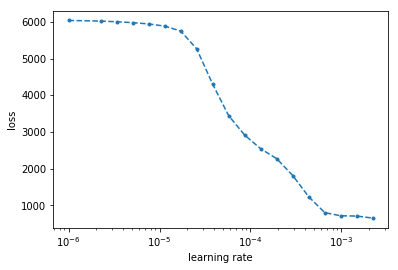

In [9]:
#plt.plot(pt_hist_lr,pt_hist_loss)
plt.xscale('log')
plt.plot(pr_hist_lr,pr_hist_loss,'.--')
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.savefig("PYRO_train.png")

In [ ]:
from PIL import Image

epoch = 10
path="./PYRO_rec_epoch_"+str(epoch)+".png"
display(Image.open(path))

# VAE in PYTORCH

In [ ]:
from encoder_decoder import *
from vae import *
encoder = Encoder_CONV(params)
decoder = Decoder_CONV(params)
vae = VAE(params,encoder,decoder)

In [ ]:
imgs_rec = vae.reconstruct(imgs_test)
show_batch(imgs_rec,nrow=4,npadding=4,title="reconstruction before training")
plt.savefig("rec_before_training.png")

In [ ]:
pt_optimizer = torch.optim.RMSprop(vae.parameters(),lr=1E-6)


In [ ]:
pt_optimizer = torch.optim.RMSprop(vae.parameters(),lr=1E-6)
pt_scheduler = torch.optim.lr_scheduler.StepLR(pt_optimizer, step_size=1, gamma=1.5, last_epoch=-1)

pt_hist_loss = []
pt_hist_lr = []
for epoch in range(0,30):
    loss_curr = one_epoch_train_VAE_pytorch(vae, trainloader, pt_optimizer, use_cuda = params['use_cuda'], verbose=(epoch==-1))
    
    # get the current lr 
    lr_curr   = pt_optimizer.param_groups[0]['lr']
    
    print("[epoch %03d] train loss: %.4f lr: %.4e" % (epoch, loss_curr, lr_curr))

    pt_hist_loss.append(loss_curr)  
    pt_hist_lr.append(lr_curr)
    pt_scheduler.step()
        
    if(np.isnan(loss_curr)):
        break 
        
    imgs_rec = vae.reconstruct(imgs_test)
    show_batch(imgs_rec,nrow=4,npadding=4,title="epoch = "+str(epoch))
    plt.savefig("PYTORCH_rec_epoch_"+str(epoch)+".png")

In [ ]:
#plt.plot(pt_hist_lr,pt_hist_loss)
plt.xscale('log')
plt.plot(pt_hist_lr,pt_hist_loss,'.--')
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.savefig("PYTORCH_train.png")

In [ ]:
from PIL import Image

epoch = 10
path="./PYTORCH_rec_epoch_"+str(epoch)+".png"
display(Image.open(path))

In [ ]:
plt.xscale('log')
plt.plot(pt_hist_lr,pt_hist_loss,'.--',label='torch')

In [ ]:
plt.xscale('log')
plt.plot(pr_hist_lr,pr_hist_loss,'.--',label='pyro')

# FROM HERE

In [ ]:
#def lr_finder(model,guide,optimizer=None, objective=None, loader=None, lr_start=1E-3, lr_multiplier=1.0, N_epoch=10, use_cuda=False):
#    
#    pyro_scheduler = pyro.optim.ExponentialLR({'optimizer': optimizer, 'optim_args': {'lr': lr_start}, 'gamma': lr_multiplier})
#    svi = SVI(model, guide, pyro_scheduler, loss=objective)
#        
#    # preparation
#    hist_loss = []
#    hist_lr = []
#    
#    for epoch in range(0,N_epoch):
#        
#        loss_cur = train(svi, loader, use_cuda=use_cuda, verbose=False)
#        lr_cur   = svi.optim.pt_optim_args['lr']
#        hist_loss.append(loss_cur)
#        hist_lr.append(lr_cur)
#        print("epoch,lr,loss %4d %.4e %.4f" %(epoch,hist_lr[-1],hist_loss[-1]))
#    
 #  return hist_loss,hist_lr

In [ ]:
#optimizer_args = {'lr': 1E-2}
#scheduler_args = {'optimizer': torch.optim.RMSprop, 'step_size' : 1, 'gamma' : 1.0, 'optim_args' : optimizer_args}
#
#pyro_scheduler = pyro.optim.StepLR(scheduler_args)
#svi = SVI(vae.model, vae.guide, pyro_scheduler, loss=Trace_ELBO(num_particles=1))
#
#
## preparation
#hist_loss = []
#hist_lr = []
#    
#for epoch in range(0,10):
#        
#    loss_cur = train(svi, trainloader, use_cuda=params['use_cuda'], verbose=False)
#    lr_cur   = svi.optim.pt_optim_args['lr']
#    hist_loss.append(loss_cur)
#    hist_lr.append(lr_cur)
#    print("epoch,lr,loss %4d %.4e %.4f" %(epoch,hist_lr[-1],hist_loss[-1]))

In [ ]:
def lr_finder(model, svi, loader, start_lr=1E-4, end_lr=10, n_mini_batch=10, lr_multiplier=1.1, epoch_delay=3, use_cuda=False):
    
    # preparation
    model.train() 
    svi.optim.pt_optim_args['lr'] = start_lr
    hist_loss = []
    hist_lr = []
    
    mini_batch = 0
    loss_tmp = 0
    epoch = -1
    while True:
        epoch += 1
        for i,data in enumerate(loader):
            
            # if on GPU put mini-batch into CUDA memory
            x, _ = data
            if use_cuda:
                x = x.cuda()
            loss = svi.step(x)
            
            #print("epoch,mini_batch,lr,loss %.4d %.4d %.4e %.4f" %(epoch,i,svi.optim.pt_optim_args['lr'],loss))
            
            mini_batch += 1
            loss_tmp += loss
            
            
            if(mini_batch % n_mini_batch == 0):            
                hist_loss.append(loss_tmp/n_mini_batch)
                hist_lr.append(svi.optim.pt_optim_args['lr'])
                print("lr,loss %.4e %.4f" %(hist_lr[-1],hist_loss[-1]))
                mini_batch = 0
                loss_tmp = 0
                if(epoch >= epoch_delay):
                    svi.optim.pt_optim_args['lr'] *= lr_multiplier
            
            if(np.isnan(loss)):
                print("loss is nan")
                return hist_loss,hist_lr
            if(not(end_lr is None) and svi.optim.pt_optim_args['lr']>end_lr):
                print("lr is bigger than end_lr")
                return hist_loss,hist_lr
    
    return hist_loss,hist_lr

In [ ]:
hist_loss,hist_lr = lr_finder(vae, svi, trainloader, 
                              start_lr=1E-4, 
                              end_lr=10, 
                              n_mini_batch=50, 
                              lr_multiplier=1.2, 
                              epoch_delay=3,
                              use_cuda=params['use_cuda'])

In [ ]:
hist_loss_2,hist_lr_2 = lr_finder(vae, svi, trainloader, 
                              start_lr=10, 
                              end_lr=1000, 
                              n_mini_batch=50, 
                              lr_multiplier=1.2, 
                              epoch_delay=0,
                              use_cuda=params['use_cuda'])

In [ ]:
hist_loss_3,hist_lr_3 = lr_finder(vae, svi, trainloader, 
                              start_lr=1000, 
                              end_lr=1E8, 
                              n_mini_batch=50, 
                              lr_multiplier=1.2, 
                              epoch_delay=0,
                              use_cuda=params['use_cuda'])

In [ ]:
#print(hist_loss,hist_lr)
#plt.xscale('log')
#plt.plot(hist_lr,hist_loss)
#plt.plot(hist_lr_2,hist_loss_2)
#plt.plot(hist_loss)
#plt.plot(hist_loss_2)
#plt.plot(hist_loss_3)

hist = hist_loss + hist_loss_2 + hist_loss_3
plt.plot(hist)


In [ ]:
optimizer = RMSprop(params=vae.params, lr=0.0001) # this is adaptive, 
len(optimizer.param_groups)

In [ ]:
for param_group in optimizer.param_groups:
    print(param_group)
    #, self.get_lr()):
    #        param_group['lr'] *= lr
        

In [ ]:
#a = svi.optim.pt_optim_args
#print(a)

In [ ]:
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#scheduler = torch.optim.CyclicLR(optimizer)
#torch.optim.lr_scheduler.StepLR
#for epoch inrange(10):train_batch(...)scheduler.step()
#optimizer = SGD({"lr": 1.0e-3, "betas":(0.9, 0.999)})

In [ ]:
# training loop
train_loss, test_loss = [], []
min_loss = 99999
for epoch in range(0,NUM_EPOCHS):
    vae.train()            
       
    loss = train(svi,trainloader,use_cuda=params['use_cuda'],verbose=(epoch ==0))
    train_loss.append(loss)   
    print("[epoch %03d] train loss: %.4f" % (epoch, loss))
    
    if(epoch % TEST_FREQUENCY == 0):
        vae.eval()
        loss = evaluate(svi,testloader,use_cuda=params['use_cuda'],verbose=(epoch ==0))
        test_loss.append(loss)
    
        if(test_loss[-1] < min_loss):
            print("[epoch %03d] test  loss: %.4f --New Record--" % (epoch, loss)) 
            min_loss = test_loss[-1]
            #### Save if you got a record 
            ###save_model(vae,write_dir,name_vae+str(epoch))       
            ###save_obj(test_loss,write_dir,name_test_loss+str(epoch))
            ###save_obj(train_loss,write_dir,name_train_loss+str(epoch))
        else:
            print("[epoch %03d] test  loss: %.4f " % (epoch, loss))
            
    if(epoch % WRITE_FREQUENCY == 0):
        save_model(vae,write_dir,name_vae+str(epoch))       
        save_obj(test_loss,write_dir,name_test_loss+str(epoch))
        save_obj(train_loss,write_dir,name_train_loss+str(epoch))


# Check the results

In [ ]:
#write_dir = '/Users/ldalessi/VAE_PYRO/ARCHIVE/'

#descriptor      = "MNIST_v1"

#load_model(vae,write_dir,"vae_"+descriptor+"_400")
#test_loss = load_obj(write_dir,"test_loss_"+descriptor+"_400")
#train_loss = load_obj(write_dir,"train_loss_"+descriptor+"_400")
#name_vae = "vae_"+descriptor

In [ ]:
from matplotlib import pyplot as plt

plt.yscale('log')
y_shift=1000
x_shift=0
plt.plot(np.arange(x_shift, x_shift+len(train_loss)), np.array(train_loss)+y_shift)
plt.plot(np.arange(x_shift, x_shift+len(train_loss), TEST_FREQUENCY), np.array(test_loss)+y_shift, '.--')
plt.xlabel('epoch')
plt.ylabel('LOSS = - ELBO')
plt.title('Training procedure')
#plt.ylim(top = 760)
#plt.xlim(xmin = 0, xmax=700)
plt.grid(True)
plt.legend(['train', 'test'])
#plt.show()


plt.savefig(write_dir+name_vae+'train.png')

In [ ]:
#imgs,labels = next(iter(testloader))
imgs,labels = next(iter(trainloader))
if(params['use_cuda']):
    imgs=imgs.cuda()
imgs_rec = vae.reconstruct(imgs)
show_2_batch(imgs[:12],imgs_rec[:12],npadding=4,nrow=6)
plt.savefig(write_dir+name_vae+'rec.png')

# compute the embedding

In [ ]:
z_tot      = np.empty([0,params['DIM_Z']])
labels_tot = np.empty([0])
for data in testloader:
    if z_tot.shape[0] >= 6000:
        break

    imgs,labels = data
    if(params['use_cuda']):
        imgs=imgs.cuda()
    z = vae.encoder(imgs)

    z_tot = np.concatenate((z_tot, z.z_mu.view(-1,params['DIM_Z']).detach().cpu().numpy()),axis=0)
    labels_tot = np.concatenate((labels_tot, labels.numpy()),axis=0)

print("z_tot.shape",z_tot.shape)
print("labels_tot.shape",labels_tot.shape)

# Clear the data

In [ ]:
z_tot[np.isnan(z_tot)] = 0
z_tot[z_tot > 100] = 0
print(z_tot.shape)
print(z_tot[labels_tot==0].shape)
print(labels_tot.shape)

In [ ]:
for k in np.unique(labels_tot):
    plt.plot(z_tot[labels_tot==k, 0], 
             z_tot[labels_tot==k, 1], '.', ms=8, alpha=0.5)

       
lgnd = plt.legend(np.unique(labels_tot).astype(int), 
                  loc='center left', bbox_to_anchor=(1, 0.5))
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._legmarker.set_markersize(20)
    lgnd.legendHandles[i]._legmarker.set_alpha(1)

plt.xlabel('z 0')
plt.ylabel('z 1')
plt.title('Visualization of raw z')
plt.box(on=None)
plt.savefig(write_dir+name_vae+'raw_z.png')

In [ ]:
cluster = dict()

for k in np.unique(labels_tot):
    mean_tmp = np.mean(z_tot[labels_tot == k],axis=0)
    #print(mean_tmp.shape)
    cluster[int(k)] = mean_tmp
cluster['all']=np.mean(z_tot,axis=0)
    

In [ ]:
print(cluster)

In [ ]:

for key in range(10):
    mean = cluster[key]
    plt.plot(mean[0],mean[1],'.', ms=20, alpha=1,label=key)
plt.plot(cluster['all'][0],cluster['all'][1],'x', ms=10, alpha=1,label='all')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.box(on=None)
plt.savefig(write_dir+name_vae+'cluster_center.png')

In [ ]:
# and I know this sounds ridiculous but we have to do more
# dimensionality reduction to visualize our dimensionality reduction

from sklearn.manifold import TSNE
z_tsne = TSNE(n_components=2).fit_transform(z_tot)

In [ ]:
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(8, 8), frameon=False)
for k in np.unique(labels_tot):
    plt.plot(z_tsne[labels_tot==k, 0], 
             z_tsne[labels_tot==k, 1], '.', ms=8, alpha=0.5)

lgnd = plt.legend(np.unique(labels_tot).astype(int), 
                  loc='center left', bbox_to_anchor=(1, 0.5))
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._legmarker.set_markersize(20)
    lgnd.legendHandles[i]._legmarker.set_alpha(1)

plt.xlabel('TSNE 0')
plt.ylabel('TSNE 1')
plt.title('Visualization of embedding')
plt.box(on=None)
plt.savefig(write_dir+name_vae+'embedding.png')